In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
dataset = '8K'

In [33]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [34]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [35]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor, min_int=None, max_int=None):
        self.sort()
        anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)

            if min_int is not None and max_int is not None:
                bd_rate = BD_RATE(R1, D1, R2, D2, min_int=min_int[filename], max_int=max_int[filename])
            else:
                bd_rate = BD_RATE(R1, D1, R2, D2)

            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor, min_int=None, max_int=None):
        ans = self._bd_rate_imgwise(anchor, min_int, max_int)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

    def time_saving(self, anchor):
        self.sort()
        anchor.sort()
        ans = []

In [36]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [37]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [38]:
# speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
speedups = [0.01,0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0]
qscales = [0.1, 0.3, 0.5, 0.7, 0.9]
# qscales = [0.3,0.4,0.5,0.6,0.7]

In [39]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [40]:
if dataset == 'classd':
    cbanet_levels = [1, 2, 3]
    cbanet_results = {k: DatasetResults() for k in cbanet_levels}
    data_cbanet = read_json(f"../../anchors/{dataset}/results_cbanet.json")

    for level in cbanet_levels:
        for bpp in [1,2,3,4]:
            glob_results = data_cbanet[f"{bpp}"][f"width={level}"]
            for filename, result in glob_results.items():
                if filename[:3] != "avg":
                    cbanet_results[level].update_image_result(
                        filename, result["bpp"], result["PSNR"], result["t_dec"] + 0.05 # ANS time extra
                    )

In [41]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [42]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'webp', 'vtm']
# if dataset == '8K':
#     anchors.remove('vtm')

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm' and dataset != '8K':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, (str, int)) or (isinstance(x.Filename, float) and not np.isnan(x.Filename)):
                if isinstance(x.Filename, float):
                    filename = str(int(x.Filename))
                else:
                    filename = str(x.Filename)
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 6.734
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg' and dataset == 'classa':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [43]:
import scipy


def interpolator(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    lin = np.linspace(min(x), max(x), num=100, retstep=True)
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(x), y[np.argsort(x)], samples
    )

    return samples, v

In [44]:
print(anchor_results)

{'bpg': <__main__.DatasetResults object at 0x7f03f0a1f430>, 'evc': <__main__.DatasetResults object at 0x7f03f0a1f9a0>, 'jpeg': <__main__.DatasetResults object at 0x7f03f337dfd0>, 'mlic': <__main__.DatasetResults object at 0x7f03f337d400>, 'qarv': <__main__.DatasetResults object at 0x7f03f337dbe0>, 'tcm': <__main__.DatasetResults object at 0x7f03f337d070>, 'webp': <__main__.DatasetResults object at 0x7f03f337dc70>, 'vtm': <__main__.DatasetResults object at 0x7f03f337dd60>}


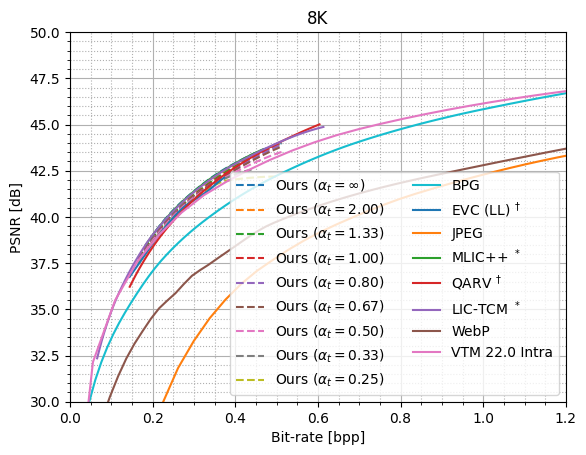

In [45]:
plt.figure(figsize=(6.4, 4.8))

name_mapping = {
    "evc": r"EVC (LL) $^\dag$",
    "mlic": "MLIC++ $^*$",
    "tcm": "LIC-TCM $^*$",
    "vtm": "VTM 22.0 Intra",
    "qarv": "QARV $^\dag$",
    "bpg": "BPG",
    "webp": "WebP",
    "jpeg": "JPEG",
}

for speedup in speedups:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    dt = 1.0 / speedup
    label = (
        f"Ours ($\\alpha_t={dt:.2f}$)" if dt <= 10 else f"Ours ($\\alpha_t=\\infty$)"
    )

    plt.plot(
        r,
        d,
        linestyle="--",
        label=label,
    )

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    if len(r) > 0:
        r, d = interpolator(r, d)
        plt.plot(r, d, label=name_mapping[k])
plt.legend(ncol=2)
plt.xlim(0.0, 1.2)
plt.ylim(30, 50)

plt.xlabel("Bit-rate [bpp]")
plt.ylabel("PSNR [dB]")
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles.get(dataset, dataset))

plt.savefig(f"{dataset}_rd.pdf", bbox_inches="tight")
plt.savefig(f"{dataset}_rd.png", dpi=600, bbox_inches="tight")
plt.show()

In [46]:
for ds, data in anchor_results.items():
    print(ds, data.img_results)

bpg {'japan-fantasy-landscape': [ResultUnit(r=0.03281017313346457, d=28.604558014654444, t=7.926145633061727), ResultUnit(r=0.05772516541964267, d=30.906594300054834, t=8.545461257298788), ResultUnit(r=0.0934400120142862, d=33.101691508077906, t=9.20327877998352), ResultUnit(r=0.14548787777295244, d=35.27177383878164, t=9.167129755020142), ResultUnit(r=0.22303863000508456, d=37.687963747762964, t=9.89850083986918), ResultUnit(r=0.32640050108364377, d=39.81475403287344, t=12.345989227294922), ResultUnit(r=0.4784407434480589, d=41.98402872064047, t=11.847567001978556), ResultUnit(r=0.7005244574741657, d=44.075518154882715, t=13.717620690663656), ResultUnit(r=1.0051025460992145, d=45.85130100824766, t=14.311840931574503), ResultUnit(r=1.4544663360753896, d=47.5230955866807, t=16.59963321685791)]}
evc {'japan-fantasy-landscape': [ResultUnit(r=0.14442637163291502, d=36.755309605383204, t=7.8054148356119795), ResultUnit(r=0.17903484165889638, d=37.860613369726465, t=8.03844396273295), Result

{'japan-fantasy-landscape': 38.48402311780386}
{'japan-fantasy-landscape': 42.12617030122213}
bpg 11.356316733360291 29.25763531137633
evc 7.962684110358909 -2.0617666960475733
jpeg 0.6749463803840405 162.61707444369003
mlic 130.06166340686656 -9.366303748054605
qarv 32.55859956596837 -1.2509484913839297
tcm 73.28167774059153 -8.99457142200627
webp 1.3307315942012903 107.72493727413507
vtm 9.72498606190537 0.0
[82.52895846366883, 52.55670512517294, 36.797562487920125, 29.1874976793925, 23.46453046798706, 19.65561803181966, 14.914644209543862, 10.109517478942871, 7.590065749486287] [-9.524639425946635, -7.983150346305834, -6.524759578029238, -5.924550603175637, -5.29139459132808, -4.916324813846728, -4.016583157706666, -2.7198913998248697, -1.9210091241319893]


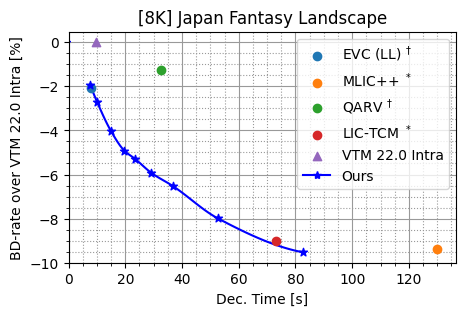

In [47]:
BD_ANCHOR = "vtm"

anchor = anchor_results[BD_ANCHOR]
min_int = {}
max_int = {}

for filename in anchor.img_results.keys():
    min_int[filename] = max(
        [
            min([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            min([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )
    max_int[filename] = min(
        [
            max([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            max([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )

print(min_int)
print(max_int)

plt.figure(figsize=(5, 3))

ts = {}
bds = {}

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    ts[k] = t
    bds[k] = bd

for k, v in anchor_results.items():
    # if k == 'evc':
    #     ts[k] = ts['qarv'] / 3.8
    if k not in ['jpeg', 'bpg', 'webp']:
        marker = '^' if k == 'vtm' else 'o'
        plt.scatter(ts[k], bds[k], label=name_mapping[k], zorder=10, marker=marker)
    print(k, ts[k], bds[k])

if dataset == "classd":
    gao_t = np.array([0.2, 1.7, 3.1, 4.4, 7.3]) / 2.0
    gao_bd = [8.7, 6.0, 5.0, 4.0, 3.0]
    t, bd = interpolator(gao_t, gao_bd)
    plt.plot(t, bd, color="orange")
    plt.scatter(gao_t, gao_bd, marker="o", color="orange")
    plt.plot([-1], [0], color="orange", marker="o", label="Gao et.al")

    cba_bd = []
    cba_t = []

    for k, v in cbanet_results.items():
        bd = v.bd_rate(anchor, min_int, max_int)
        t = np.mean(v.avg_t)
        cba_bd.append(bd)
        cba_t.append(t)
    
    plt.plot(cba_t, cba_bd, color='teal')
    plt.scatter(cba_t, cba_bd, marker='o', color='teal', zorder=10)
    plt.plot([-1], [0], marker="o", color="teal", label="CBANet")

    # plt.title(titles[dataset])
    # plt.legend()

    # plt.savefig(f"{dataset}_bd_gao.pdf", bbox_inches="tight")
    # plt.savefig(f"{dataset}_bd_gao.png", dpi=600, bbox_inches="tight")

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    t = min(t, ts['qarv'] / k)
    ours_bd.append(bd)
    ours_t.append(t)

print(ours_t, ours_bd)

ours_t = np.asarray(ours_t)
ours_bd = np.asarray(ours_bd)
ours_bd, ours_t = np.sort(ours_bd), ours_t[np.argsort(ours_bd)]
t, bd = interpolator(ours_t, ours_bd)

plt.plot(t, bd, color='blue')
plt.scatter(ours_t, ours_bd, marker='*', color='blue', zorder=10)
plt.plot([-1], [0], marker="*", color="blue", label="Ours")
plt.xlabel("Dec. Time [s]")
xmin, xmax = plt.xlim()
plt.xlim(0, xmax)
plt.ylabel("BD-rate over VTM 22.0 Intra [%]")
plt.minorticks_on()
plt.grid(zorder=0, which='major', color='#999999', linestyle='-')
plt.grid(zorder=0, which='minor', color='#999999', linestyle=':')
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
    "8K": "[8K] Japan Fantasy Landscape",
}
plt.title(titles[dataset])

plt.legend()

plt.savefig(f"{dataset}_bd_c.pdf", bbox_inches='tight')
plt.savefig(f"{dataset}_bd_c.png", dpi=600, bbox_inches="tight")

In [48]:
ours_bd, ours_t

(array([-9.52463943, -7.98315035, -6.52475958, -5.9245506 , -5.29139459,
        -4.91632481, -4.01658316, -2.7198914 , -1.92100912]),
 array([82.52895846, 52.55670513, 36.79756249, 29.18749768, 23.46453047,
        19.65561803, 14.91464421, 10.10951748,  7.59006575]))

In [60]:
# Accelerate Effect

import scipy.interpolate


for method in ts.keys():
    t = ts[method]
    bd = bds[method]

    if bd > max(ours_bd):
        t_est = min(ours_t)
    else:
        t_est = scipy.interpolate.pchip_interpolate(ours_bd, ours_t, bd)
    print(method, 100*(t_est-t)/t)

bpg -33.16437074012099
evc 0.5833090708576195
jpeg 1024.5435148741126
mlic -39.41108859166706
qarv -76.6879845857383
tcm -3.739637988261934
webp 470.3678925607738
vtm -21.952939560314366


In [50]:
# Accelerate Effect

import scipy.interpolate

ours_t = np.asarray(ours_t)
ours_bd = np.asarray(ours_bd)

print(ours_t, ours_bd, flush=True)

for method in ts.keys():
    t = ts[method]
    bd = bds[method]
    if t > max(ours_t):
        bd_est = min(ours_bd)
    else:
        X = np.sort(ours_t)
        Y = ours_bd[np.argsort(ours_t)]
        bd_est = scipy.interpolate.pchip_interpolate(X, Y, t)
    print(method, bd_est - bd)

[82.52895846 52.55670513 36.79756249 29.18749768 23.46453047 19.65561803
 14.91464421 10.10951748  7.59006575] [-9.52463943 -7.98315035 -6.52475958 -5.9245506  -5.29139459 -4.91632481
 -4.01658316 -2.7198914  -1.92100912]
bpg -32.341796022637936
evc 0.01712770246320483
jpeg -162.40860723021936
mlic -0.15833567789202974
qarv -4.949495455016336
tcm -0.2065587632110759
webp -107.67578860428478
vtm -2.605135370473995


In [51]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults, rng_anchor: DatasetResults = None):
    ans_results = results._bd_rate_imgwise(anchor, min_int, max_int)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x: x[1])
    print(ans_results)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

In [52]:
import matplotlib as mpl


def plot_img_results_comparison(
    results1: DatasetResults, results2, anchor: DatasetResults
):
    ans_results1 = results1._bd_rate_imgwise(anchor)
    ans_results2 = results2._bd_rate_imgwise(anchor)
    ans_results2 = [(k, ans_results1[k] - v) for k, v in ans_results2.items()]
    ans_results2.sort(key=lambda x: x[1])
    print(ans_results2)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps["coolwarm"]
    labels, values = zip(*ans_results2)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis="y", zorder=0)
    plt.xticks(rotation=90)

[('japan-fantasy-landscape', -0.6719793502245386)]


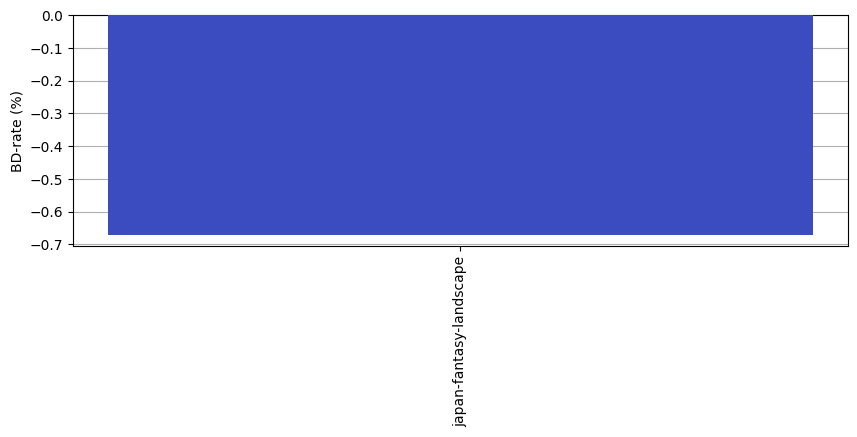

In [53]:
plot_img_results(ours_results[3.0], anchor_results["evc"])

[('japan-fantasy-landscape', -5.228388080117107)]


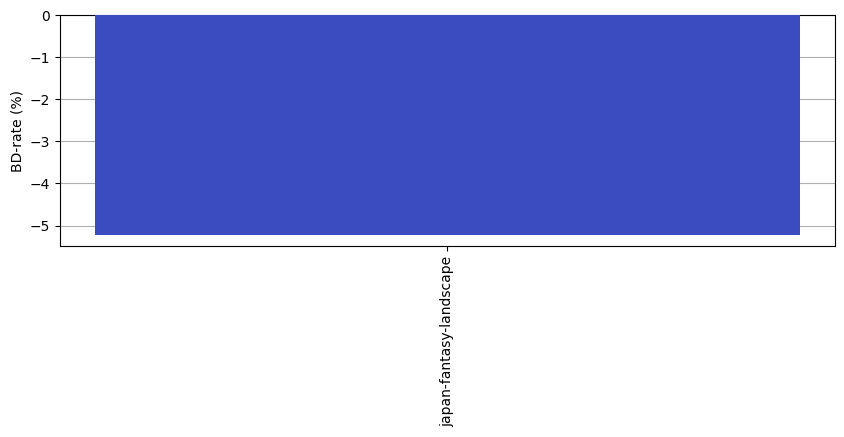

In [54]:
plot_img_results_comparison(ours_results[0.01], anchor_results["tcm"], anchor_results["vtm"])
plt.savefig(f"ours_tcm_imgwise_{dataset}.pdf", bbox_inches="tight")
plt.savefig(f"ours_tcm_imgwise_{dataset}.png", dpi=600, bbox_inches="tight")

[('japan-fantasy-landscape', -4.204883349968513)]


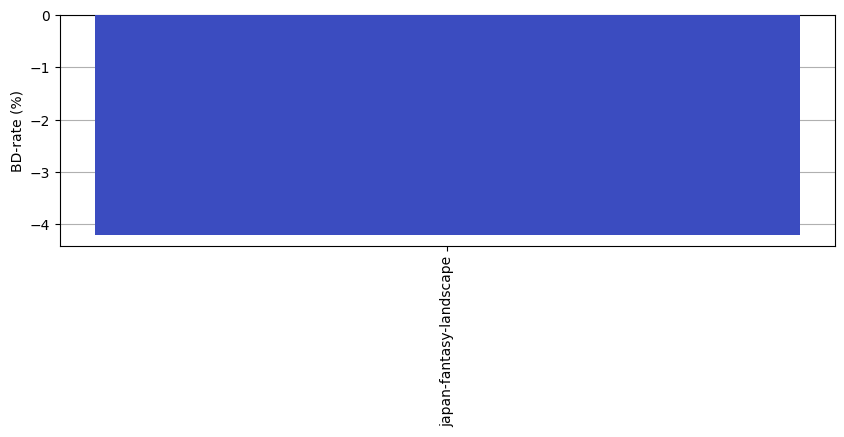

In [55]:
plot_img_results_comparison(
    ours_results[1.0], anchor_results["qarv"], anchor_results["vtm"]
)
plt.savefig(f"ours_qarv_imgwise_{dataset}.pdf", bbox_inches='tight')
plt.savefig(f"ours_qarv_imgwise_{dataset}.png", dpi=600, bbox_inches="tight")

[('japan-fantasy-landscape', -1.9959686791493292)]


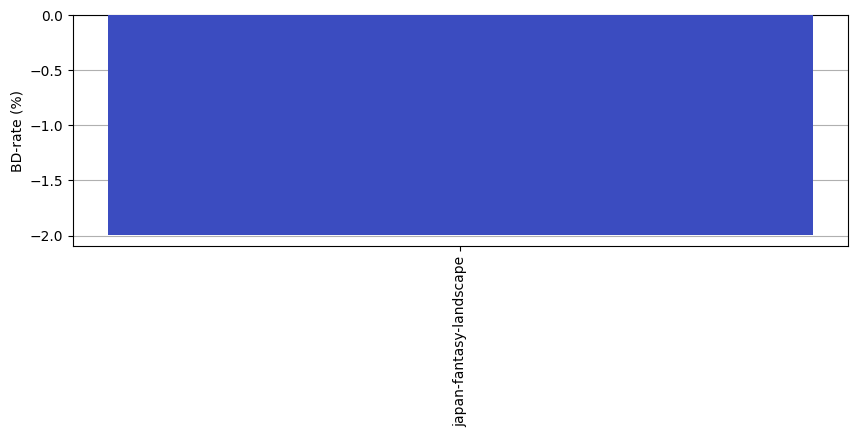

In [56]:
plot_img_results(
    ours_results[2.0], anchor_results["evc"]
)

In [57]:
def f(imgresult, label):
    plt.plot([x.r for x in imgresult], [x.d for x in imgresult], label=label, marker='o')

f(anchor_results["vtm"].img_results["DSC08902"], "vtm")
f(anchor_results["evc"].img_results["DSC08902"], "evc")
# f(anchor_results["mlic"].img_results["DSC05885"], "mlic")
f(ours_results[3.0].img_results["DSC08902"], "ours")
plt.legend()

KeyError: 'DSC08902'

In [ ]:
from src.fileio import FileIO

glb3 = glob.glob("classc/PSNR/speedup-2.0/*/DSC08927.bin")

for filename in glb3:
    fileio = FileIO.load(filename, False, 512)
    print(filename, fileio.method_id)

classc/PSNR/speedup-2.0/qscale-0.1/DSC08927.bin [1 4 0 4 4 1 0 1 4 0 0 1]
classc/PSNR/speedup-2.0/qscale-0.7/DSC08927.bin [1 1 0 1 1 1 1 1 1 1 1 1]
classc/PSNR/speedup-2.0/qscale-0.5/DSC08927.bin [1 1 0 1 1 1 0 1 1 1 1 4]
classc/PSNR/speedup-2.0/qscale-0.3/DSC08927.bin [1 1 0 4 4 1 0 1 4 0 0 4]
classc/PSNR/speedup-2.0/qscale-0.9/DSC08927.bin [1 1 0 1 1 1 1 1 1 0 1 1]
